# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from keras.layers.core import Dense, Dropout, Activation
from sklearn.metrics import mean_absolute_error
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.models import Model
import keras
import sys, time
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Reading Dataset

In [4]:
# load dataset
BASE_PATH = "Selected_Data/"
ROI = ["VC", "V1", "V2", "V3", "V4", "VC", "FFA", "LOC", "LVC", "PPA"]
data_list = os.listdir(BASE_PATH)

X_percept = np.load(BASE_PATH + "VC_X_train.npy")
X_imagery = np.load(BASE_PATH + "VC_X_test.npy")
y_percept = np.load(BASE_PATH + "VC_y_train.npy")
y_imagery = np.load(BASE_PATH + "VC_y_test.npy")

In [5]:
def preProcessData(X, y, mode):
    scaler = StandardScaler()
    encoder = LabelEncoder()
    if (mode == "Combined"):
        scaler.fit(X)
        X = scaler.transform(X)
        # encode class values as integers
        encoder.fit(y)
        y = encoder.transform(y)
        
        return X, y
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        # encode class values as integers

        encoder.fit(y_train)
        y_train = encoder.transform(y_train)
        y_test = encoder.transform(y_test)

        print(f"[{mode}] Train_X: {X_train.shape}, Train_y: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
        print(f"Number of classes in Train: {len(np.unique(y_train))} , Number of classes in Test: {len(np.unique(y_test))}")

        return X_train, X_test, y_train, y_test

### Get Perception (pt) & Imagery (im) Data

In [6]:
X_train_pt, X_test_pt, y_train_pt, y_test_pt = preProcessData(X_percept, y_percept, "Perception")
X_train_im, X_test_im, y_train_im, y_test_im = preProcessData(X_imagery, y_imagery, "Imagery")

# combine data
combined_X = np.concatenate((X_train_pt, X_train_im), axis=0)
combined_y = np.hstack((y_train_pt, y_train_im))

print(f"Combined Shape X, y: {combined_X.shape}, {combined_y.shape}")

combined_X, combined_y = shuffle(combined_X, combined_y) # since they are concatenated at the last, shuffle and preserve indices
X_train_cb, y_train_cb = preProcessData(combined_X, combined_y, "Combined")

[Perception] Train_X: (1172, 4466), Train_y: (1172,), X_test: (578, 4466), y_test: (578,)
Number of classes in Train: 50 , Number of classes in Test: 50
[Imagery] Train_X: (335, 4466), Train_y: (335,), X_test: (165, 4466), y_test: (165,)
Number of classes in Train: 50 , Number of classes in Test: 49
Combined Shape X, y: (1507, 4466), (1507,)


# Training

## Logistic Regression

In [8]:
def logReg(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(verbose=2).fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(predictions, y_test)
    return accuracy

### Experiment A. (Perception Train Perception Test)

In [9]:
accuracy_logReg_a = logReg(X_train_pt, X_test_pt, y_train_pt, y_test_pt)
print(f"Accuracy: {accuracy_logReg_a}")

[LibLinear]Accuracy: 0.9602076124567474


### Experiment B. (Imagery Train Imagery Test) 

In [10]:
accuracy_logReg_b = logReg(X_train_im, X_test_im, y_train_im, y_test_im)
print(f"Accuracy: {accuracy_logReg_b}")

[LibLinear]Accuracy: 0.0


### Experiment C. (Perception Train Imagery Test) 

In [11]:
accuracy_logReg_c = logReg(X_train_pt, X_test_im, y_train_pt, y_test_im)
print(f"Accuracy: {accuracy_logReg_c}")

[LibLinear]Accuracy: 0.024242424242424242


### Experiment D. (Combined Train Combined Test) 

In [12]:
accuracy_logReg_d_im = logReg(X_train_cb, X_test_im, y_train_cb, y_test_im)
print(f"Imagery Accuracy: {accuracy_logReg_d_im}")

accuracy_logReg_d_pt = logReg(X_train_cb, X_test_pt, y_train_cb, y_test_pt)
print(f"Perception Accuracy: {accuracy_logReg_d_pt}")

[LibLinear]Imagery Accuracy: 0.0
[LibLinear]Perception Accuracy: 0.9100346020761245


## AlexNet

In [22]:
def alexNet(pretrained_weights = None,input_size = (4466,)):
    
    inputs = Input(input_size)
    dense1 = Dense(64, activation='relu', kernel_initializer = 'he_normal')(inputs)
    bn1 = BatchNormalization()(dense1)
    dropout1 = Dropout(0.5)(bn1)
    dense2 = Dense(128, activation='relu', kernel_initializer = 'he_normal')(dropout1)
    bn2 = BatchNormalization()(dense2)
    dropout2 = Dropout(0.5)(bn2)
    dense3 = Dense(512, activation='relu',kernel_initializer = 'he_normal')(dropout2)
    bn3 = BatchNormalization()(dense3)
    dropout3 = Dropout(0.5)(bn3)
    dense4 = Dense(512, activation='relu',kernel_initializer = 'he_normal')(dropout3)
    dense5 = Dense(256, activation='relu',kernel_initializer = 'he_normal')(dense4)
    dropout4 = Dropout(0.5)(dense5)
    dense6 = Dense(128, activation='relu',kernel_initializer = 'he_normal')(dropout4)
    dense7 = Dense(64, activation='relu',kernel_initializer = 'he_normal')(dense6)
    bn7 = BatchNormalization()(dense7)

    dense8 = Dense(50, activation='softmax')(bn7)
    model = Model(input = inputs, output = dense8)
    model.compile(loss='sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 1e-4), metrics=['accuracy'])
    
    if(pretrained_weights):
        print('loading_weights')
        model.load_weights(pretrained_weights)

    return model

In [23]:
def fit_alexNet(X_train, X_test, y_train, y_test):
    model = alexNet(input_size=(X_train.shape[1],))
    print(model.summary())
    model = alexNet(input_size=(X_train.shape[1],))
    history = model.fit(X_train, y_train, batch_size=64, epochs=500, validation_data=(X_test, y_test), shuffle=True, verbose=2)
    
    score = model.evaluate(X_test, y_test, batch_size=16)    
    return score, history

def plot_acc(history, file_name):
    plt.plot(history.history['acc'], label="train")
    plt.plot(history.history['val_acc'], label="val")
    plt.title("Accuracy Curve Train vs Val")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(file_name, dpi=300)
    plt.show()
    
def plot_loss(history, file_name):
    plt.plot(history.history['loss'], label="train")
    plt.plot(history.history['val_loss'], label="val")
    plt.title("Loss Curve Train vs Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(file_name, dpi=300)
    plt.show()

### Experiment A. (Perception Train Perception Test)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4466)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                285888    
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0   

Epoch 67/500
 - 0s - loss: 3.9921 - acc: 0.0341 - val_loss: 3.9935 - val_acc: 0.0173
Epoch 68/500
 - 0s - loss: 3.9754 - acc: 0.0265 - val_loss: 3.9919 - val_acc: 0.0173
Epoch 69/500
 - 0s - loss: 3.9863 - acc: 0.0282 - val_loss: 3.9941 - val_acc: 0.0173
Epoch 70/500
 - 0s - loss: 3.9849 - acc: 0.0290 - val_loss: 3.9973 - val_acc: 0.0156
Epoch 71/500
 - 0s - loss: 3.9600 - acc: 0.0367 - val_loss: 3.9966 - val_acc: 0.0156
Epoch 72/500
 - 0s - loss: 3.9872 - acc: 0.0375 - val_loss: 3.9923 - val_acc: 0.0156
Epoch 73/500
 - 0s - loss: 3.9819 - acc: 0.0282 - val_loss: 3.9917 - val_acc: 0.0156
Epoch 74/500
 - 0s - loss: 4.0031 - acc: 0.0333 - val_loss: 3.9897 - val_acc: 0.0173
Epoch 75/500
 - 0s - loss: 3.9799 - acc: 0.0282 - val_loss: 3.9890 - val_acc: 0.0173
Epoch 76/500
 - 0s - loss: 3.9590 - acc: 0.0358 - val_loss: 3.9871 - val_acc: 0.0190
Epoch 77/500
 - 0s - loss: 3.9764 - acc: 0.0418 - val_loss: 3.9872 - val_acc: 0.0190
Epoch 78/500
 - 0s - loss: 3.9433 - acc: 0.0341 - val_loss: 3.985

Epoch 163/500
 - 0s - loss: 3.5383 - acc: 0.1015 - val_loss: 3.9578 - val_acc: 0.0450
Epoch 164/500
 - 0s - loss: 3.5359 - acc: 0.0836 - val_loss: 3.9470 - val_acc: 0.0484
Epoch 165/500
 - 0s - loss: 3.5192 - acc: 0.0947 - val_loss: 3.9553 - val_acc: 0.0467
Epoch 166/500
 - 0s - loss: 3.5023 - acc: 0.1032 - val_loss: 3.9607 - val_acc: 0.0450
Epoch 167/500
 - 0s - loss: 3.5019 - acc: 0.0990 - val_loss: 3.9547 - val_acc: 0.0450
Epoch 168/500
 - 0s - loss: 3.4905 - acc: 0.0870 - val_loss: 3.9539 - val_acc: 0.0450
Epoch 169/500
 - 0s - loss: 3.4764 - acc: 0.0862 - val_loss: 3.9596 - val_acc: 0.0415
Epoch 170/500
 - 0s - loss: 3.4926 - acc: 0.1015 - val_loss: 3.9603 - val_acc: 0.0415
Epoch 171/500
 - 0s - loss: 3.4864 - acc: 0.0947 - val_loss: 3.9540 - val_acc: 0.0398
Epoch 172/500
 - 0s - loss: 3.4767 - acc: 0.0956 - val_loss: 3.9512 - val_acc: 0.0415
Epoch 173/500
 - 0s - loss: 3.4604 - acc: 0.1126 - val_loss: 3.9465 - val_acc: 0.0415
Epoch 174/500
 - 0s - loss: 3.4588 - acc: 0.1032 - val

Epoch 259/500
 - 0s - loss: 2.5624 - acc: 0.2995 - val_loss: 3.2040 - val_acc: 0.1574
Epoch 260/500
 - 0s - loss: 2.5658 - acc: 0.3020 - val_loss: 3.1985 - val_acc: 0.1471
Epoch 261/500
 - 0s - loss: 2.5474 - acc: 0.3038 - val_loss: 3.1523 - val_acc: 0.1609
Epoch 262/500
 - 0s - loss: 2.5778 - acc: 0.2833 - val_loss: 3.1425 - val_acc: 0.1540
Epoch 263/500
 - 0s - loss: 2.5229 - acc: 0.2995 - val_loss: 3.1271 - val_acc: 0.1609
Epoch 264/500
 - 0s - loss: 2.5295 - acc: 0.2969 - val_loss: 3.1039 - val_acc: 0.1626
Epoch 265/500
 - 0s - loss: 2.4893 - acc: 0.3200 - val_loss: 3.0927 - val_acc: 0.1765
Epoch 266/500
 - 0s - loss: 2.4574 - acc: 0.3447 - val_loss: 3.0973 - val_acc: 0.1696
Epoch 267/500
 - 0s - loss: 2.4668 - acc: 0.3208 - val_loss: 3.1016 - val_acc: 0.1626
Epoch 268/500
 - 0s - loss: 2.4857 - acc: 0.3106 - val_loss: 3.0806 - val_acc: 0.1644
Epoch 269/500
 - 0s - loss: 2.4398 - acc: 0.3328 - val_loss: 3.0665 - val_acc: 0.1678
Epoch 270/500
 - 0s - loss: 2.4593 - acc: 0.3276 - val

Epoch 355/500
 - 0s - loss: 1.5943 - acc: 0.5410 - val_loss: 2.2053 - val_acc: 0.3875
Epoch 356/500
 - 0s - loss: 1.5612 - acc: 0.5648 - val_loss: 2.1945 - val_acc: 0.3910
Epoch 357/500
 - 0s - loss: 1.5610 - acc: 0.5631 - val_loss: 2.1819 - val_acc: 0.3997
Epoch 358/500
 - 0s - loss: 1.5314 - acc: 0.5725 - val_loss: 2.1939 - val_acc: 0.3962
Epoch 359/500
 - 0s - loss: 1.5201 - acc: 0.5717 - val_loss: 2.1614 - val_acc: 0.3841
Epoch 360/500
 - 0s - loss: 1.5224 - acc: 0.5700 - val_loss: 2.1568 - val_acc: 0.3945
Epoch 361/500
 - 0s - loss: 1.5062 - acc: 0.5648 - val_loss: 2.1783 - val_acc: 0.3997
Epoch 362/500
 - 0s - loss: 1.5245 - acc: 0.5768 - val_loss: 2.1259 - val_acc: 0.4014
Epoch 363/500
 - 1s - loss: 1.5188 - acc: 0.5802 - val_loss: 2.1218 - val_acc: 0.4048
Epoch 364/500
 - 1s - loss: 1.5341 - acc: 0.5768 - val_loss: 2.1158 - val_acc: 0.3910
Epoch 365/500
 - 1s - loss: 1.4874 - acc: 0.5811 - val_loss: 2.1307 - val_acc: 0.3806
Epoch 366/500
 - 1s - loss: 1.4852 - acc: 0.5930 - val

Epoch 451/500
 - 1s - loss: 1.0382 - acc: 0.7048 - val_loss: 1.7104 - val_acc: 0.4965
Epoch 452/500
 - 1s - loss: 1.0126 - acc: 0.7056 - val_loss: 1.6815 - val_acc: 0.5173
Epoch 453/500
 - 1s - loss: 0.9748 - acc: 0.7261 - val_loss: 1.6923 - val_acc: 0.5156
Epoch 454/500
 - 1s - loss: 0.9708 - acc: 0.7244 - val_loss: 1.7086 - val_acc: 0.5104
Epoch 455/500
 - 1s - loss: 0.9558 - acc: 0.7244 - val_loss: 1.6912 - val_acc: 0.5138
Epoch 456/500
 - 1s - loss: 0.9573 - acc: 0.7338 - val_loss: 1.6642 - val_acc: 0.5398
Epoch 457/500
 - 1s - loss: 0.9487 - acc: 0.7449 - val_loss: 1.6377 - val_acc: 0.5346
Epoch 458/500
 - 1s - loss: 0.9110 - acc: 0.7543 - val_loss: 1.6476 - val_acc: 0.5225
Epoch 459/500
 - 1s - loss: 0.8975 - acc: 0.7483 - val_loss: 1.6439 - val_acc: 0.5398
Epoch 460/500
 - 1s - loss: 0.9284 - acc: 0.7398 - val_loss: 1.6530 - val_acc: 0.5398
Epoch 461/500
 - 1s - loss: 0.9387 - acc: 0.7338 - val_loss: 1.6751 - val_acc: 0.5363
Epoch 462/500
 - 1s - loss: 0.9090 - acc: 0.7449 - val

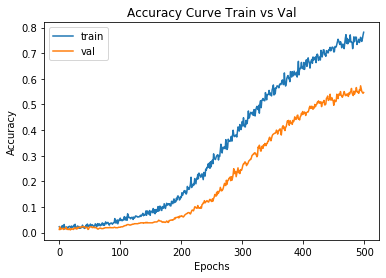

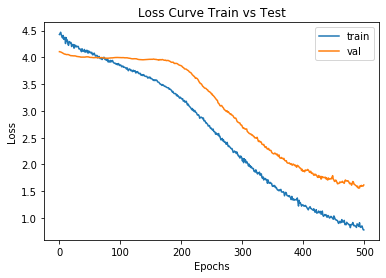

In [15]:
score, history = fit_alexNet(X_train_pt, X_test_pt, y_train_pt, y_test_pt)
print(f"Accuracy: {score}")

file_name = "Results_IMGS/Acc_AlexNet_Perception_Train_Perception_Test.png"
plot_acc(history, file_name)
file_name = "Results_IMGS/Loss_AlexNet_Perception_Train_Perception_Test.png"
plot_loss(history, file_name)

### Experiment B. (Imagery Train Imagery Test)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 4466)              0         
_________________________________________________________________
dense_63 (Dense)             (None, 64)                285888    
_________________________________________________________________
batch_normalization_29 (Batc (None, 64)                256       
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_30 (Batc (None, 128)               512       
_________________________________________________________________
dropout_38 (Dropout)         (None, 128)               0   

Epoch 66/1000
 - 1s - loss: 4.1781 - acc: 0.0179 - val_loss: 4.0474 - val_acc: 0.0182
Epoch 67/1000
 - 1s - loss: 4.1061 - acc: 0.0060 - val_loss: 4.0463 - val_acc: 0.0182
Epoch 68/1000
 - 1s - loss: 4.0471 - acc: 0.0119 - val_loss: 4.0461 - val_acc: 0.0182
Epoch 69/1000
 - 1s - loss: 4.0988 - acc: 0.0239 - val_loss: 4.0467 - val_acc: 0.0242
Epoch 70/1000
 - 1s - loss: 4.0238 - acc: 0.0388 - val_loss: 4.0441 - val_acc: 0.0242
Epoch 71/1000
 - 1s - loss: 4.0776 - acc: 0.0179 - val_loss: 4.0476 - val_acc: 0.0242
Epoch 72/1000
 - 1s - loss: 4.0447 - acc: 0.0299 - val_loss: 4.0494 - val_acc: 0.0242
Epoch 73/1000
 - 1s - loss: 4.0890 - acc: 0.0239 - val_loss: 4.0444 - val_acc: 0.0121
Epoch 74/1000
 - 1s - loss: 4.0646 - acc: 0.0149 - val_loss: 4.0471 - val_acc: 0.0121
Epoch 75/1000
 - 1s - loss: 4.1006 - acc: 0.0358 - val_loss: 4.0472 - val_acc: 0.0182
Epoch 76/1000
 - 1s - loss: 4.0452 - acc: 0.0299 - val_loss: 4.0419 - val_acc: 0.0182
Epoch 77/1000
 - 1s - loss: 4.0542 - acc: 0.0239 - val

Epoch 161/1000
 - 1s - loss: 3.8505 - acc: 0.0478 - val_loss: 4.0867 - val_acc: 0.0061
Epoch 162/1000
 - 1s - loss: 3.8562 - acc: 0.0328 - val_loss: 4.0891 - val_acc: 0.0061
Epoch 163/1000
 - 1s - loss: 3.8444 - acc: 0.0567 - val_loss: 4.0906 - val_acc: 0.0061
Epoch 164/1000
 - 1s - loss: 3.8640 - acc: 0.0478 - val_loss: 4.0927 - val_acc: 0.0061
Epoch 165/1000
 - 1s - loss: 3.8409 - acc: 0.0507 - val_loss: 4.0945 - val_acc: 0.0061
Epoch 166/1000
 - 1s - loss: 3.8728 - acc: 0.0418 - val_loss: 4.0962 - val_acc: 0.0061
Epoch 167/1000
 - 1s - loss: 3.8463 - acc: 0.0478 - val_loss: 4.0975 - val_acc: 0.0061
Epoch 168/1000
 - 1s - loss: 3.8022 - acc: 0.0448 - val_loss: 4.0975 - val_acc: 0.0061
Epoch 169/1000
 - 1s - loss: 3.8263 - acc: 0.0358 - val_loss: 4.0988 - val_acc: 0.0061
Epoch 170/1000
 - 1s - loss: 3.8371 - acc: 0.0597 - val_loss: 4.0968 - val_acc: 0.0061
Epoch 171/1000
 - 1s - loss: 3.8145 - acc: 0.0567 - val_loss: 4.0970 - val_acc: 0.0061
Epoch 172/1000
 - 1s - loss: 3.8212 - acc: 

Epoch 255/1000
 - 1s - loss: 3.6952 - acc: 0.0776 - val_loss: 4.1661 - val_acc: 0.0121
Epoch 256/1000
 - 1s - loss: 3.6332 - acc: 0.0716 - val_loss: 4.1658 - val_acc: 0.0121
Epoch 257/1000
 - 1s - loss: 3.6721 - acc: 0.0687 - val_loss: 4.1655 - val_acc: 0.0121
Epoch 258/1000
 - 1s - loss: 3.6959 - acc: 0.0687 - val_loss: 4.1667 - val_acc: 0.0061
Epoch 259/1000
 - 1s - loss: 3.6486 - acc: 0.0866 - val_loss: 4.1644 - val_acc: 0.0061
Epoch 260/1000
 - 1s - loss: 3.6209 - acc: 0.0776 - val_loss: 4.1645 - val_acc: 0.0061
Epoch 261/1000
 - 1s - loss: 3.6217 - acc: 0.0716 - val_loss: 4.1654 - val_acc: 0.0061
Epoch 262/1000
 - 1s - loss: 3.6082 - acc: 0.0866 - val_loss: 4.1689 - val_acc: 0.0061
Epoch 263/1000
 - 1s - loss: 3.6197 - acc: 0.0687 - val_loss: 4.1713 - val_acc: 0.0061
Epoch 264/1000
 - 1s - loss: 3.6879 - acc: 0.0687 - val_loss: 4.1701 - val_acc: 0.0061
Epoch 265/1000
 - 1s - loss: 3.6432 - acc: 0.0925 - val_loss: 4.1738 - val_acc: 0.0061
Epoch 266/1000
 - 1s - loss: 3.6191 - acc: 

Epoch 349/1000
 - 1s - loss: 3.3600 - acc: 0.1075 - val_loss: 4.2745 - val_acc: 0.0182
Epoch 350/1000
 - 1s - loss: 3.3130 - acc: 0.1194 - val_loss: 4.2755 - val_acc: 0.0182
Epoch 351/1000
 - 1s - loss: 3.3637 - acc: 0.1284 - val_loss: 4.2734 - val_acc: 0.0121
Epoch 352/1000
 - 1s - loss: 3.3800 - acc: 0.0985 - val_loss: 4.2778 - val_acc: 0.0121
Epoch 353/1000
 - 1s - loss: 3.3740 - acc: 0.1164 - val_loss: 4.2813 - val_acc: 0.0121
Epoch 354/1000
 - 0s - loss: 3.3816 - acc: 0.1045 - val_loss: 4.2747 - val_acc: 0.0182
Epoch 355/1000
 - 0s - loss: 3.3699 - acc: 0.1075 - val_loss: 4.2781 - val_acc: 0.0182
Epoch 356/1000
 - 0s - loss: 3.3582 - acc: 0.1313 - val_loss: 4.2767 - val_acc: 0.0121
Epoch 357/1000
 - 0s - loss: 3.3856 - acc: 0.1343 - val_loss: 4.2806 - val_acc: 0.0121
Epoch 358/1000
 - 0s - loss: 3.3812 - acc: 0.1194 - val_loss: 4.2794 - val_acc: 0.0182
Epoch 359/1000
 - 0s - loss: 3.3341 - acc: 0.1254 - val_loss: 4.2808 - val_acc: 0.0182
Epoch 360/1000
 - 0s - loss: 3.4218 - acc: 

 - 0s - loss: 3.0272 - acc: 0.1851 - val_loss: 4.4030 - val_acc: 0.0182
Epoch 444/1000
 - 0s - loss: 2.9821 - acc: 0.1851 - val_loss: 4.4242 - val_acc: 0.0182
Epoch 445/1000
 - 0s - loss: 3.0437 - acc: 0.1552 - val_loss: 4.4317 - val_acc: 0.0242
Epoch 446/1000
 - 0s - loss: 3.0158 - acc: 0.2030 - val_loss: 4.4290 - val_acc: 0.0242
Epoch 447/1000
 - 0s - loss: 2.9080 - acc: 0.2209 - val_loss: 4.4385 - val_acc: 0.0242
Epoch 448/1000
 - 0s - loss: 2.9985 - acc: 0.1970 - val_loss: 4.4454 - val_acc: 0.0303
Epoch 449/1000
 - 0s - loss: 2.9921 - acc: 0.1881 - val_loss: 4.4498 - val_acc: 0.0303
Epoch 450/1000
 - 0s - loss: 2.9243 - acc: 0.1940 - val_loss: 4.4384 - val_acc: 0.0242
Epoch 451/1000
 - 0s - loss: 3.0066 - acc: 0.1910 - val_loss: 4.4518 - val_acc: 0.0242
Epoch 452/1000
 - 1s - loss: 2.9454 - acc: 0.1791 - val_loss: 4.4511 - val_acc: 0.0242
Epoch 453/1000
 - 1s - loss: 3.0567 - acc: 0.1552 - val_loss: 4.4545 - val_acc: 0.0242
Epoch 454/1000
 - 1s - loss: 2.9649 - acc: 0.2299 - val_lo

Epoch 538/1000
 - 1s - loss: 2.5840 - acc: 0.3134 - val_loss: 4.6490 - val_acc: 0.0242
Epoch 539/1000
 - 1s - loss: 2.6415 - acc: 0.2746 - val_loss: 4.6390 - val_acc: 0.0303
Epoch 540/1000
 - 1s - loss: 2.6198 - acc: 0.2567 - val_loss: 4.6394 - val_acc: 0.0303
Epoch 541/1000
 - 1s - loss: 2.5735 - acc: 0.2896 - val_loss: 4.6485 - val_acc: 0.0242
Epoch 542/1000
 - 1s - loss: 2.6128 - acc: 0.2657 - val_loss: 4.6618 - val_acc: 0.0182
Epoch 543/1000
 - 1s - loss: 2.5731 - acc: 0.2776 - val_loss: 4.6714 - val_acc: 0.0242
Epoch 544/1000
 - 1s - loss: 2.5297 - acc: 0.2716 - val_loss: 4.6612 - val_acc: 0.0303
Epoch 545/1000
 - 1s - loss: 2.5958 - acc: 0.2836 - val_loss: 4.6505 - val_acc: 0.0364
Epoch 546/1000
 - 1s - loss: 2.6042 - acc: 0.2687 - val_loss: 4.6505 - val_acc: 0.0182
Epoch 547/1000
 - 1s - loss: 2.5617 - acc: 0.2896 - val_loss: 4.6624 - val_acc: 0.0303
Epoch 548/1000
 - 1s - loss: 2.5229 - acc: 0.2955 - val_loss: 4.6609 - val_acc: 0.0424
Epoch 549/1000
 - 1s - loss: 2.5335 - acc: 

 - 1s - loss: 2.1693 - acc: 0.3761 - val_loss: 4.8987 - val_acc: 0.0424
Epoch 633/1000
 - 1s - loss: 2.2155 - acc: 0.3493 - val_loss: 4.8844 - val_acc: 0.0424
Epoch 634/1000
 - 1s - loss: 2.1263 - acc: 0.3821 - val_loss: 4.9065 - val_acc: 0.0303
Epoch 635/1000
 - 1s - loss: 2.1234 - acc: 0.3821 - val_loss: 4.9391 - val_acc: 0.0242
Epoch 636/1000
 - 1s - loss: 2.1358 - acc: 0.4000 - val_loss: 4.9408 - val_acc: 0.0242
Epoch 637/1000
 - 1s - loss: 2.1514 - acc: 0.4358 - val_loss: 4.9358 - val_acc: 0.0242
Epoch 638/1000
 - 1s - loss: 2.2025 - acc: 0.3672 - val_loss: 4.9723 - val_acc: 0.0303
Epoch 639/1000
 - 1s - loss: 2.2223 - acc: 0.3582 - val_loss: 4.9728 - val_acc: 0.0364
Epoch 640/1000
 - 1s - loss: 2.1894 - acc: 0.3940 - val_loss: 4.9680 - val_acc: 0.0364
Epoch 641/1000
 - 1s - loss: 2.0834 - acc: 0.4358 - val_loss: 4.9679 - val_acc: 0.0303
Epoch 642/1000
 - 1s - loss: 2.2166 - acc: 0.3791 - val_loss: 4.9662 - val_acc: 0.0364
Epoch 643/1000
 - 1s - loss: 2.2103 - acc: 0.3701 - val_lo

Epoch 727/1000
 - 1s - loss: 1.7448 - acc: 0.4925 - val_loss: 5.3509 - val_acc: 0.0242
Epoch 728/1000
 - 1s - loss: 1.7644 - acc: 0.4896 - val_loss: 5.3493 - val_acc: 0.0182
Epoch 729/1000
 - 1s - loss: 1.7955 - acc: 0.4896 - val_loss: 5.3731 - val_acc: 0.0182
Epoch 730/1000
 - 1s - loss: 1.8946 - acc: 0.4597 - val_loss: 5.3866 - val_acc: 0.0303
Epoch 731/1000
 - 1s - loss: 1.7503 - acc: 0.4716 - val_loss: 5.3568 - val_acc: 0.0303
Epoch 732/1000
 - 1s - loss: 1.8937 - acc: 0.4119 - val_loss: 5.3824 - val_acc: 0.0303
Epoch 733/1000
 - 1s - loss: 1.8691 - acc: 0.4239 - val_loss: 5.3826 - val_acc: 0.0242
Epoch 734/1000
 - 1s - loss: 1.9125 - acc: 0.4328 - val_loss: 5.3874 - val_acc: 0.0242
Epoch 735/1000
 - 1s - loss: 1.9164 - acc: 0.4388 - val_loss: 5.4039 - val_acc: 0.0182
Epoch 736/1000
 - 0s - loss: 1.8340 - acc: 0.4627 - val_loss: 5.4082 - val_acc: 0.0182
Epoch 737/1000
 - 0s - loss: 1.7957 - acc: 0.4716 - val_loss: 5.4503 - val_acc: 0.0303
Epoch 738/1000
 - 0s - loss: 1.9285 - acc: 

 - 0s - loss: 1.5626 - acc: 0.5343 - val_loss: 5.7724 - val_acc: 0.0061
Epoch 822/1000
 - 0s - loss: 1.6024 - acc: 0.5403 - val_loss: 5.7409 - val_acc: 0.0061
Epoch 823/1000
 - 0s - loss: 1.5313 - acc: 0.5493 - val_loss: 5.7535 - val_acc: 0.0121
Epoch 824/1000
 - 0s - loss: 1.5140 - acc: 0.5433 - val_loss: 5.7081 - val_acc: 0.0121
Epoch 825/1000
 - 0s - loss: 1.4824 - acc: 0.5701 - val_loss: 5.8564 - val_acc: 0.0061
Epoch 826/1000
 - 0s - loss: 1.5556 - acc: 0.5075 - val_loss: 5.8372 - val_acc: 0.0182
Epoch 827/1000
 - 0s - loss: 1.5157 - acc: 0.5612 - val_loss: 5.8035 - val_acc: 0.0182
Epoch 828/1000
 - 0s - loss: 1.5803 - acc: 0.5104 - val_loss: 5.8325 - val_acc: 0.0182
Epoch 829/1000
 - 1s - loss: 1.5289 - acc: 0.5284 - val_loss: 5.8647 - val_acc: 0.0061
Epoch 830/1000
 - 1s - loss: 1.5313 - acc: 0.5612 - val_loss: 5.8558 - val_acc: 0.0061
Epoch 831/1000
 - 1s - loss: 1.4836 - acc: 0.5493 - val_loss: 5.8812 - val_acc: 0.0000e+00
Epoch 832/1000
 - 1s - loss: 1.3855 - acc: 0.5910 - va

 - 0s - loss: 1.4185 - acc: 0.5642 - val_loss: 6.2351 - val_acc: 0.0061
Epoch 916/1000
 - 0s - loss: 1.3174 - acc: 0.6299 - val_loss: 6.1910 - val_acc: 0.0000e+00
Epoch 917/1000
 - 0s - loss: 1.3048 - acc: 0.6119 - val_loss: 6.1600 - val_acc: 0.0061
Epoch 918/1000
 - 0s - loss: 1.2161 - acc: 0.6507 - val_loss: 6.1240 - val_acc: 0.0121
Epoch 919/1000
 - 0s - loss: 1.2439 - acc: 0.6299 - val_loss: 6.1642 - val_acc: 0.0061
Epoch 920/1000
 - 0s - loss: 1.2316 - acc: 0.6388 - val_loss: 6.2049 - val_acc: 0.0000e+00
Epoch 921/1000
 - 0s - loss: 1.3279 - acc: 0.5940 - val_loss: 6.1640 - val_acc: 0.0000e+00
Epoch 922/1000
 - 0s - loss: 1.3932 - acc: 0.6000 - val_loss: 6.0804 - val_acc: 0.0182
Epoch 923/1000
 - 1s - loss: 1.2879 - acc: 0.6448 - val_loss: 6.0999 - val_acc: 0.0182
Epoch 924/1000
 - 1s - loss: 1.3660 - acc: 0.5940 - val_loss: 6.1387 - val_acc: 0.0000e+00
Epoch 925/1000
 - 1s - loss: 1.3291 - acc: 0.5970 - val_loss: 6.1531 - val_acc: 0.0000e+00
Epoch 926/1000
 - 1s - loss: 1.2864 - 

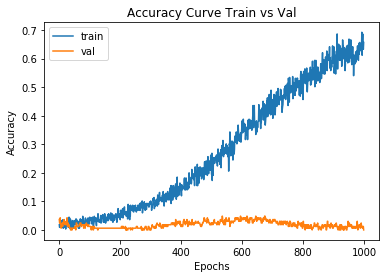

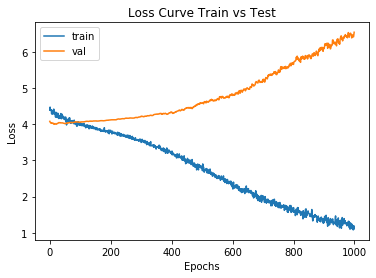

In [20]:
score, history = fit_alexNet(X_train_im, X_test_im, y_train_im, y_test_im)
print(f"Accuracy: {score}")
file_name = "Results_IMGS/Acc_AlexNet_Imagery_Train_Imagery_Test.png"
plot_acc(history, file_name)
file_name = "Results_IMGS/Loss_AlexNet_Imagery_Train_Imagery_Test.png"
plot_loss(history, file_name)

### Experiment C. (Perception Train Imagery Test)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 4466)              0         
_________________________________________________________________
dense_111 (Dense)            (None, 64)                285888    
_________________________________________________________________
batch_normalization_53 (Batc (None, 64)                256       
_________________________________________________________________
dropout_61 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_112 (Dense)            (None, 128)               8320      
_________________________________________________________________
batch_normalization_54 (Batc (None, 128)               512       
_________________________________________________________________
dropout_62 (Dropout)         (None, 128)               0  

Epoch 67/500
 - 0s - loss: 4.0344 - acc: 0.0256 - val_loss: 3.9568 - val_acc: 0.0242
Epoch 68/500
 - 0s - loss: 3.9988 - acc: 0.0290 - val_loss: 3.9569 - val_acc: 0.0242
Epoch 69/500
 - 0s - loss: 3.9844 - acc: 0.0358 - val_loss: 3.9571 - val_acc: 0.0242
Epoch 70/500
 - 0s - loss: 3.9995 - acc: 0.0273 - val_loss: 3.9582 - val_acc: 0.0242
Epoch 71/500
 - 0s - loss: 3.9984 - acc: 0.0358 - val_loss: 3.9591 - val_acc: 0.0242
Epoch 72/500
 - 0s - loss: 3.9917 - acc: 0.0350 - val_loss: 3.9622 - val_acc: 0.0242
Epoch 73/500
 - 0s - loss: 4.0004 - acc: 0.0299 - val_loss: 3.9638 - val_acc: 0.0242
Epoch 74/500
 - 0s - loss: 4.0208 - acc: 0.0282 - val_loss: 3.9657 - val_acc: 0.0303
Epoch 75/500
 - 0s - loss: 3.9884 - acc: 0.0299 - val_loss: 3.9659 - val_acc: 0.0242
Epoch 76/500
 - 0s - loss: 3.9541 - acc: 0.0333 - val_loss: 3.9669 - val_acc: 0.0242
Epoch 77/500
 - 0s - loss: 3.9518 - acc: 0.0282 - val_loss: 3.9668 - val_acc: 0.0242
Epoch 78/500
 - 0s - loss: 3.9686 - acc: 0.0324 - val_loss: 3.966

 - 1s - loss: 3.5922 - acc: 0.0742 - val_loss: 4.1796 - val_acc: 0.0121
Epoch 163/500
 - 1s - loss: 3.6017 - acc: 0.0759 - val_loss: 4.1815 - val_acc: 0.0121
Epoch 164/500
 - 1s - loss: 3.5657 - acc: 0.0717 - val_loss: 4.1875 - val_acc: 0.0121
Epoch 165/500
 - 1s - loss: 3.5800 - acc: 0.0828 - val_loss: 4.1950 - val_acc: 0.0182
Epoch 166/500
 - 1s - loss: 3.5643 - acc: 0.0802 - val_loss: 4.1995 - val_acc: 0.0242
Epoch 167/500
 - 1s - loss: 3.5654 - acc: 0.0776 - val_loss: 4.2059 - val_acc: 0.0242
Epoch 168/500
 - 1s - loss: 3.5329 - acc: 0.0776 - val_loss: 4.2103 - val_acc: 0.0303
Epoch 169/500
 - 1s - loss: 3.5554 - acc: 0.0768 - val_loss: 4.2175 - val_acc: 0.0364
Epoch 170/500
 - 1s - loss: 3.5421 - acc: 0.0828 - val_loss: 4.2203 - val_acc: 0.0364
Epoch 171/500
 - 1s - loss: 3.5288 - acc: 0.0896 - val_loss: 4.2212 - val_acc: 0.0303
Epoch 172/500
 - 1s - loss: 3.4976 - acc: 0.0964 - val_loss: 4.2275 - val_acc: 0.0303
Epoch 173/500
 - 1s - loss: 3.5155 - acc: 0.0845 - val_loss: 4.2264 

Epoch 258/500
 - 0s - loss: 2.7033 - acc: 0.2637 - val_loss: 4.6088 - val_acc: 0.0303
Epoch 259/500
 - 0s - loss: 2.7170 - acc: 0.2671 - val_loss: 4.6084 - val_acc: 0.0364
Epoch 260/500
 - 0s - loss: 2.6890 - acc: 0.2688 - val_loss: 4.6243 - val_acc: 0.0303
Epoch 261/500
 - 0s - loss: 2.7073 - acc: 0.2602 - val_loss: 4.6481 - val_acc: 0.0242
Epoch 262/500
 - 0s - loss: 2.6514 - acc: 0.2944 - val_loss: 4.6708 - val_acc: 0.0242
Epoch 263/500
 - 0s - loss: 2.6659 - acc: 0.2765 - val_loss: 4.6846 - val_acc: 0.0182
Epoch 264/500
 - 0s - loss: 2.6698 - acc: 0.2662 - val_loss: 4.6871 - val_acc: 0.0242
Epoch 265/500
 - 0s - loss: 2.6066 - acc: 0.3072 - val_loss: 4.6987 - val_acc: 0.0182
Epoch 266/500
 - 0s - loss: 2.6169 - acc: 0.3038 - val_loss: 4.7069 - val_acc: 0.0182
Epoch 267/500
 - 0s - loss: 2.6220 - acc: 0.2961 - val_loss: 4.6972 - val_acc: 0.0182
Epoch 268/500
 - 0s - loss: 2.5815 - acc: 0.3029 - val_loss: 4.7083 - val_acc: 0.0182
Epoch 269/500
 - 0s - loss: 2.5763 - acc: 0.3140 - val

Epoch 354/500
 - 1s - loss: 1.6252 - acc: 0.5666 - val_loss: 5.6126 - val_acc: 0.0121
Epoch 355/500
 - 1s - loss: 1.6160 - acc: 0.5614 - val_loss: 5.6057 - val_acc: 0.0182
Epoch 356/500
 - 1s - loss: 1.6205 - acc: 0.5708 - val_loss: 5.5881 - val_acc: 0.0182
Epoch 357/500
 - 1s - loss: 1.6099 - acc: 0.5495 - val_loss: 5.5756 - val_acc: 0.0182
Epoch 358/500
 - 1s - loss: 1.5943 - acc: 0.5614 - val_loss: 5.5998 - val_acc: 0.0182
Epoch 359/500
 - 1s - loss: 1.5829 - acc: 0.5640 - val_loss: 5.6302 - val_acc: 0.0182
Epoch 360/500
 - 1s - loss: 1.5914 - acc: 0.5674 - val_loss: 5.6311 - val_acc: 0.0182
Epoch 361/500
 - 1s - loss: 1.5691 - acc: 0.5555 - val_loss: 5.6381 - val_acc: 0.0182
Epoch 362/500
 - 1s - loss: 1.5772 - acc: 0.5708 - val_loss: 5.6761 - val_acc: 0.0182
Epoch 363/500
 - 1s - loss: 1.5835 - acc: 0.5631 - val_loss: 5.6669 - val_acc: 0.0242
Epoch 364/500
 - 1s - loss: 1.5538 - acc: 0.5674 - val_loss: 5.6794 - val_acc: 0.0182
Epoch 365/500
 - 1s - loss: 1.5353 - acc: 0.5802 - val

Epoch 450/500
 - 1s - loss: 1.0142 - acc: 0.7278 - val_loss: 6.9190 - val_acc: 0.0061
Epoch 451/500
 - 1s - loss: 0.9940 - acc: 0.7142 - val_loss: 6.8646 - val_acc: 0.0182
Epoch 452/500
 - 1s - loss: 0.9781 - acc: 0.7287 - val_loss: 6.8704 - val_acc: 0.0182
Epoch 453/500
 - 1s - loss: 1.0006 - acc: 0.7235 - val_loss: 6.9024 - val_acc: 0.0061
Epoch 454/500
 - 1s - loss: 0.9925 - acc: 0.7201 - val_loss: 6.9216 - val_acc: 0.0061
Epoch 455/500
 - 1s - loss: 0.9821 - acc: 0.7210 - val_loss: 6.8785 - val_acc: 0.0121
Epoch 456/500
 - 1s - loss: 0.9485 - acc: 0.7193 - val_loss: 6.8834 - val_acc: 0.0121
Epoch 457/500
 - 1s - loss: 0.9857 - acc: 0.7218 - val_loss: 6.8899 - val_acc: 0.0061
Epoch 458/500
 - 1s - loss: 0.9763 - acc: 0.7244 - val_loss: 6.9369 - val_acc: 0.0061
Epoch 459/500
 - 1s - loss: 0.9706 - acc: 0.7355 - val_loss: 6.9507 - val_acc: 0.0061
Epoch 460/500
 - 1s - loss: 0.9992 - acc: 0.7108 - val_loss: 6.9767 - val_acc: 0.0061
Epoch 461/500
 - 1s - loss: 0.9643 - acc: 0.7389 - val

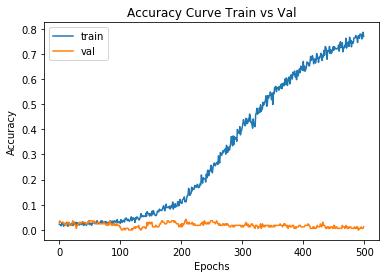

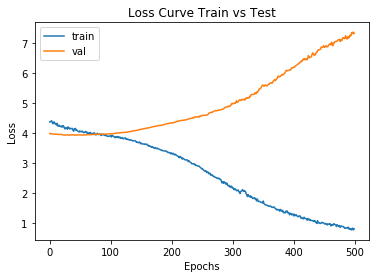

In [25]:
score, history = fit_alexNet(X_train_pt, X_test_im, y_train_pt, y_test_im)
print(f"Accuracy: {score}")
file_name = "Results_IMGS/Acc_AlexNet_Perception_Train_Imagery_Test.png"
plot_acc(history, file_name)
file_name = "Results_IMGS/Loss_AlexNet_Perception_Train_Imagery_Test.png"
plot_loss(history, file_name)

### Experiment D. (Combined Train Combined Test)

Imagery Accuracy: [7.498843817277388, 0.024242424242424242]


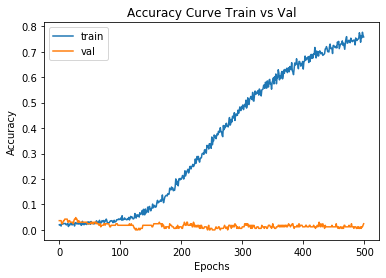

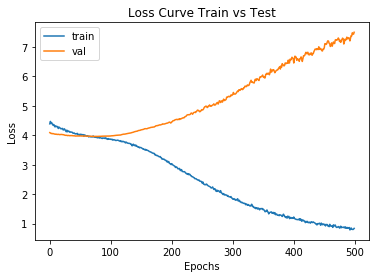

Perception Accuracy: [1.704018959124608, 0.5519031141868512]


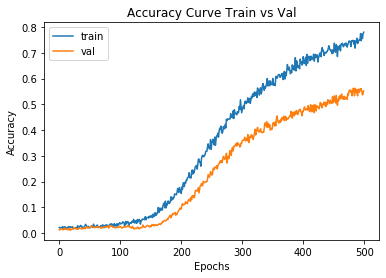

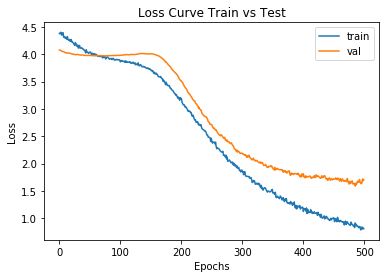

In [27]:
score_im, history_im = fit_alexNet(X_train_cb, X_test_im, y_train_cb, y_test_im)
print(f"Imagery Accuracy: {score_im}")
file_name = "Results_IMGS/Acc_AlexNet_Combined_Train_Imagery_Test.png"
plot_acc(history_im, file_name)
file_name = "Results_IMGS/Loss_AlexNet_Combined_Train_Imagery_Test.png"
plot_loss(history_im, file_name)


score_pt, history_pt = fit_alexNet(X_train_cb, X_test_pt, y_train_cb, y_test_pt)
print(f"Perception Accuracy: {score_pt}")
file_name = "Results_IMGS/Acc_AlexNet_Combined_Train_Perception_Test.png"
plot_acc(history_pt, file_name)
file_name = "Results_IMGS/Loss_AlexNet_Combined_Train_Perception_Test.png"
plot_loss(history_pt, file_name)

## 1-Layer MLP

In [28]:
def one_layer_mlp(input_size = (4466,)):
    inputs = Input(input_size)
    dense1 = Dense(64, activation='relu', kernel_initializer = 'he_normal')(inputs)
    bn1 = BatchNormalization()(dense1)
    dropout1 = Dropout(0.5)(bn1)
    dense2 = Dense(50, activation='softmax')(dropout1)

    model = Model(input = inputs, output = dense2)
    model.compile(loss='sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(lr = 1e-4), metrics=['accuracy'])

    return model

In [29]:
def fit_one_layer_mlp(X_train, X_test, y_train, y_test):
    model = one_layer_mlp(input_size=(X_train.shape[1],))
    model.summary()
    model = one_layer_mlp(input_size=(X_train.shape[1],))
    history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test), shuffle=True, verbose=2)
    
    score = model.evaluate(X_test, y_test, batch_size=16)    
    return score, history

def plot_acc(history, file_name):
    plt.plot(history.history['acc'], label="train")
    plt.plot(history.history['val_acc'], label="val")
    plt.title("Accuracy Curve Train vs Val")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(file_name, dpi=300)
    plt.show()
    
def plot_loss(history, file_name):
    plt.plot(history.history['loss'], label="train")
    plt.plot(history.history['val_loss'], label="val")
    plt.title("Loss Curve Train vs Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(file_name, dpi=300)
    plt.show()

### Experiment A. (Perception Train Perception Test)

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 4466)              0         
_________________________________________________________________
dense_159 (Dense)            (None, 64)                285888    
_________________________________________________________________
batch_normalization_77 (Batc (None, 64)                256       
_________________________________________________________________
dropout_85 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_160 (Dense)            (None, 50)                3250      
Total params: 289,394
Trainable params: 289,266
Non-trainable params: 128
_________________________________________________________________
Train on 1172 samples, validate on 578 samples
Epoch 1/100
 - 3s - loss: 4.8812 - acc: 0.0162 - val_loss: 4.1910 - v

Epoch 85/100
 - 1s - loss: 0.1500 - acc: 0.9846 - val_loss: 1.2834 - val_acc: 0.7076
Epoch 86/100
 - 1s - loss: 0.1399 - acc: 0.9923 - val_loss: 1.2983 - val_acc: 0.6851
Epoch 87/100
 - 1s - loss: 0.1183 - acc: 0.9983 - val_loss: 1.2225 - val_acc: 0.7249
Epoch 88/100
 - 1s - loss: 0.1227 - acc: 0.9898 - val_loss: 1.2554 - val_acc: 0.7007
Epoch 89/100
 - 1s - loss: 0.1068 - acc: 0.9923 - val_loss: 1.2171 - val_acc: 0.7180
Epoch 90/100
 - 1s - loss: 0.1247 - acc: 0.9923 - val_loss: 1.2612 - val_acc: 0.7007
Epoch 91/100
 - 1s - loss: 0.1205 - acc: 0.9940 - val_loss: 1.2264 - val_acc: 0.7128
Epoch 92/100
 - 1s - loss: 0.1276 - acc: 0.9932 - val_loss: 1.2436 - val_acc: 0.7076
Epoch 93/100
 - 1s - loss: 0.1429 - acc: 0.9915 - val_loss: 1.2587 - val_acc: 0.7042
Epoch 94/100
 - 1s - loss: 0.1328 - acc: 0.9881 - val_loss: 1.2168 - val_acc: 0.7042
Epoch 95/100
 - 1s - loss: 0.1533 - acc: 0.9829 - val_loss: 1.2687 - val_acc: 0.6886
Epoch 96/100
 - 1s - loss: 0.1390 - acc: 0.9906 - val_loss: 1.270

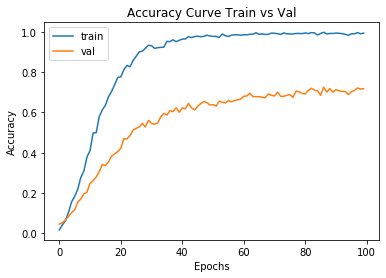

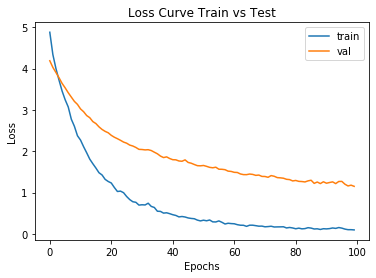

In [30]:
score, history = fit_one_layer_mlp(X_train_pt, X_test_pt, y_train_pt, y_test_pt)
print(f"Accuracy: {score}")
file_name = "Results_IMGS/Acc_1MLP_Perception_Train_Perception_Test.png"
plot_acc(history, file_name)
file_name = "Results_IMGS/Loss_1MLP_Perception_Train_Perception_Test.png"
plot_loss(history, file_name)

### Experiment B. (Imagery Train Imagery Test)

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 4466)              0         
_________________________________________________________________
dense_163 (Dense)            (None, 64)                285888    
_________________________________________________________________
batch_normalization_79 (Batc (None, 64)                256       
_________________________________________________________________
dropout_87 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_164 (Dense)            (None, 50)                3250      
Total params: 289,394
Trainable params: 289,266
Non-trainable params: 128
_________________________________________________________________
Train on 335 samples, validate on 165 samples
Epoch 1/100
 - 3s - loss: 4.9480 - acc: 0.0179 - val_loss: 4.3649 - va

Epoch 84/100
 - 0s - loss: 0.7236 - acc: 0.9164 - val_loss: 4.7850 - val_acc: 0.0000e+00
Epoch 85/100
 - 0s - loss: 0.6525 - acc: 0.9403 - val_loss: 4.8084 - val_acc: 0.0000e+00
Epoch 86/100
 - 0s - loss: 0.6951 - acc: 0.9403 - val_loss: 4.8081 - val_acc: 0.0061
Epoch 87/100
 - 0s - loss: 0.6746 - acc: 0.9254 - val_loss: 4.8175 - val_acc: 0.0061
Epoch 88/100
 - 0s - loss: 0.5971 - acc: 0.9433 - val_loss: 4.8199 - val_acc: 0.0061
Epoch 89/100
 - 0s - loss: 0.6896 - acc: 0.9433 - val_loss: 4.7893 - val_acc: 0.0061
Epoch 90/100
 - 0s - loss: 0.6463 - acc: 0.9463 - val_loss: 4.8008 - val_acc: 0.0121
Epoch 91/100
 - 0s - loss: 0.6446 - acc: 0.9254 - val_loss: 4.7760 - val_acc: 0.0182
Epoch 92/100
 - 0s - loss: 0.6330 - acc: 0.9403 - val_loss: 4.7911 - val_acc: 0.0121
Epoch 93/100
 - 0s - loss: 0.5842 - acc: 0.9403 - val_loss: 4.7961 - val_acc: 0.0061
Epoch 94/100
 - 0s - loss: 0.6301 - acc: 0.9373 - val_loss: 4.7705 - val_acc: 0.0121
Epoch 95/100
 - 0s - loss: 0.5845 - acc: 0.9642 - val_los

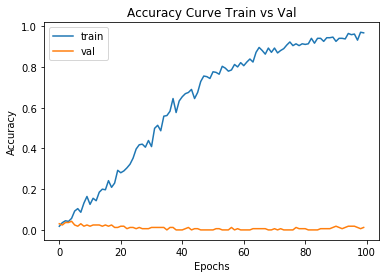

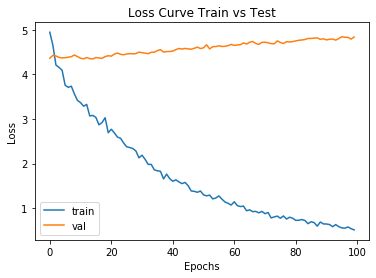

In [31]:
score, history = fit_one_layer_mlp(X_train_im, X_test_im, y_train_im, y_test_im)
print(f"Accuracy: {score}")
file_name = "Results_IMGS/Acc_1MLP_Imagery_Train_Imagery_Test.png"
plot_acc(history, file_name)
file_name = "Results_IMGS/Loss_1MLP_Imagery_Train_Imagery_Test.png"
plot_loss(history, file_name)

### Experiment C. (Perception Train Imagery Test)

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 4466)              0         
_________________________________________________________________
dense_167 (Dense)            (None, 64)                285888    
_________________________________________________________________
batch_normalization_81 (Batc (None, 64)                256       
_________________________________________________________________
dropout_89 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_168 (Dense)            (None, 50)                3250      
Total params: 289,394
Trainable params: 289,266
Non-trainable params: 128
_________________________________________________________________
Train on 1172 samples, validate on 165 samples
Epoch 1/100
 - 3s - loss: 4.8704 - acc: 0.0171 - val_loss: 4.5293 - v

Epoch 85/100
 - 1s - loss: 0.1126 - acc: 0.9974 - val_loss: 4.9857 - val_acc: 0.0364
Epoch 86/100
 - 1s - loss: 0.1086 - acc: 0.9949 - val_loss: 5.0320 - val_acc: 0.0182
Epoch 87/100
 - 1s - loss: 0.1104 - acc: 0.9974 - val_loss: 5.0153 - val_acc: 0.0242
Epoch 88/100
 - 1s - loss: 0.1125 - acc: 0.9949 - val_loss: 5.0549 - val_acc: 0.0303
Epoch 89/100
 - 1s - loss: 0.1043 - acc: 0.9966 - val_loss: 5.0131 - val_acc: 0.0303
Epoch 90/100
 - 1s - loss: 0.1126 - acc: 0.9915 - val_loss: 5.1126 - val_acc: 0.0364
Epoch 91/100
 - 1s - loss: 0.1077 - acc: 0.9923 - val_loss: 5.0687 - val_acc: 0.0303
Epoch 92/100
 - 1s - loss: 0.1045 - acc: 0.9957 - val_loss: 5.1528 - val_acc: 0.0364
Epoch 93/100
 - 1s - loss: 0.1119 - acc: 0.9932 - val_loss: 5.1349 - val_acc: 0.0242
Epoch 94/100
 - 1s - loss: 0.0991 - acc: 0.9932 - val_loss: 5.0725 - val_acc: 0.0242
Epoch 95/100
 - 1s - loss: 0.1210 - acc: 0.9966 - val_loss: 5.1339 - val_acc: 0.0242
Epoch 96/100
 - 1s - loss: 0.1263 - acc: 0.9932 - val_loss: 5.179

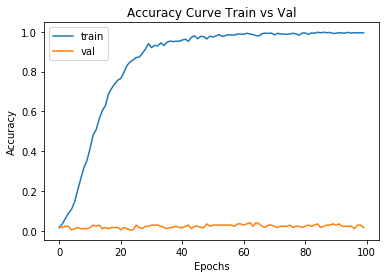

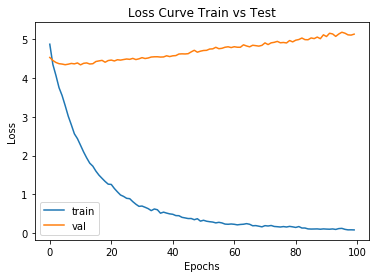

In [32]:
score, history = fit_one_layer_mlp(X_train_pt, X_test_im, y_train_pt, y_test_im)
print(f"Accuracy: {score}")
file_name = "Results_IMGS/Acc_1MLP_Perception_Train_Imagery_Test.png"
plot_acc(history, file_name)
file_name = "Results_IMGS/Loss_1MLP_Perception_Train_Imagery_Test.png"
plot_loss(history, file_name)

### Experiment D. (Combined Train Combined Test)

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 4466)              0         
_________________________________________________________________
dense_171 (Dense)            (None, 64)                285888    
_________________________________________________________________
batch_normalization_83 (Batc (None, 64)                256       
_________________________________________________________________
dropout_91 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_172 (Dense)            (None, 50)                3250      
Total params: 289,394
Trainable params: 289,266
Non-trainable params: 128
_________________________________________________________________
Train on 1507 samples, validate on 165 samples
Epoch 1/100
 - 3s - loss: 4.8662 - acc: 0.0239 - val_loss: 4.2411 - v

Epoch 85/100
 - 1s - loss: 0.2488 - acc: 0.9681 - val_loss: 5.2829 - val_acc: 0.0000e+00
Epoch 86/100
 - 1s - loss: 0.2272 - acc: 0.9715 - val_loss: 5.2268 - val_acc: 0.0242
Epoch 87/100
 - 1s - loss: 0.2219 - acc: 0.9662 - val_loss: 5.3469 - val_acc: 0.0121
Epoch 88/100
 - 1s - loss: 0.2391 - acc: 0.9628 - val_loss: 5.3411 - val_acc: 0.0182
Epoch 89/100
 - 1s - loss: 0.2188 - acc: 0.9695 - val_loss: 5.3418 - val_acc: 0.0121
Epoch 90/100
 - 1s - loss: 0.2541 - acc: 0.9595 - val_loss: 5.2864 - val_acc: 0.0061
Epoch 91/100
 - 1s - loss: 0.2550 - acc: 0.9536 - val_loss: 5.3459 - val_acc: 0.0121
Epoch 92/100
 - 1s - loss: 0.2511 - acc: 0.9608 - val_loss: 5.4327 - val_acc: 0.0061
Epoch 93/100
 - 1s - loss: 0.2358 - acc: 0.9582 - val_loss: 5.4025 - val_acc: 0.0182
Epoch 94/100
 - 1s - loss: 0.2240 - acc: 0.9695 - val_loss: 5.3769 - val_acc: 0.0242
Epoch 95/100
 - 1s - loss: 0.2650 - acc: 0.9569 - val_loss: 5.3745 - val_acc: 0.0303
Epoch 96/100
 - 1s - loss: 0.2258 - acc: 0.9655 - val_loss: 5

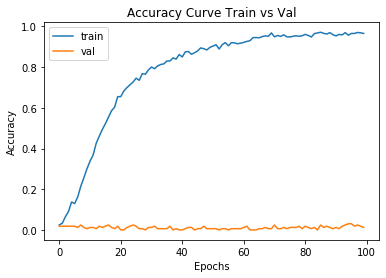

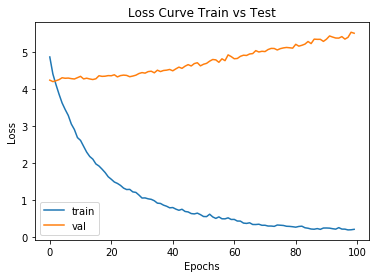

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 4466)              0         
_________________________________________________________________
dense_175 (Dense)            (None, 64)                285888    
_________________________________________________________________
batch_normalization_85 (Batc (None, 64)                256       
_________________________________________________________________
dropout_93 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_176 (Dense)            (None, 50)                3250      
Total params: 289,394
Trainable params: 289,266
Non-trainable params: 128
_________________________________________________________________
Train on 1507 samples, validate on 578 samples
Epoch 1/100
 - 4s - loss: 4.8636 - acc: 0.0226 - val_loss: 4.3086 - v

Epoch 85/100
 - 1s - loss: 0.2663 - acc: 0.9542 - val_loss: 1.4955 - val_acc: 0.6211
Epoch 86/100
 - 1s - loss: 0.2421 - acc: 0.9662 - val_loss: 1.4926 - val_acc: 0.6211
Epoch 87/100
 - 1s - loss: 0.2394 - acc: 0.9662 - val_loss: 1.4851 - val_acc: 0.6315
Epoch 88/100
 - 1s - loss: 0.2199 - acc: 0.9708 - val_loss: 1.4850 - val_acc: 0.6471
Epoch 89/100
 - 1s - loss: 0.2396 - acc: 0.9622 - val_loss: 1.4685 - val_acc: 0.6367
Epoch 90/100
 - 2s - loss: 0.3046 - acc: 0.9409 - val_loss: 1.5181 - val_acc: 0.6159
Epoch 91/100
 - 1s - loss: 0.2720 - acc: 0.9622 - val_loss: 1.5359 - val_acc: 0.6263
Epoch 92/100
 - 1s - loss: 0.2938 - acc: 0.9476 - val_loss: 1.5735 - val_acc: 0.6003
Epoch 93/100
 - 1s - loss: 0.2679 - acc: 0.9589 - val_loss: 1.5306 - val_acc: 0.6298
Epoch 94/100
 - 1s - loss: 0.2595 - acc: 0.9489 - val_loss: 1.4891 - val_acc: 0.6211
Epoch 95/100
 - 1s - loss: 0.2537 - acc: 0.9575 - val_loss: 1.5048 - val_acc: 0.6021
Epoch 96/100
 - 1s - loss: 0.2514 - acc: 0.9589 - val_loss: 1.481

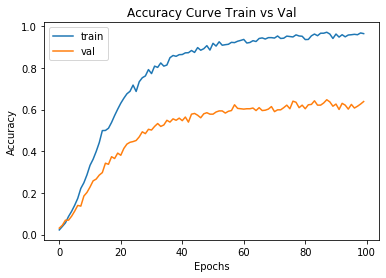

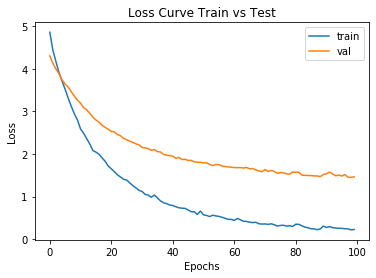

In [33]:
score_im, history_im = fit_one_layer_mlp(X_train_cb, X_test_im, y_train_cb, y_test_im)
print(f"Imagery Accuracy: {score_im}")
file_name = "Results_IMGS/Acc_1MLP_Combined_Train_Imagery_Test.png"
plot_acc(history_im, file_name)
file_name = "Results_IMGS/Loss_1MLP_Combined_Train_Imagery_Test.png"
plot_loss(history_im, file_name)

score_pt, history_pt = fit_one_layer_mlp(X_train_cb, X_test_pt, y_train_cb, y_test_pt)
print(f"Perception Accuracy: {score_pt}")
file_name = "Results_IMGS/Acc_1MLP_Combined_Train_Perception_Test.png"
plot_acc(history_pt, file_name)
file_name = "Results_IMGS/Loss_1MLP_Combined_Train_Perception_Test.png"
plot_loss(history_pt, file_name)